In [1]:
import turbo as tb
import rul_dataframe as rd
import plots as pl
import labeling as lb
import preprocessing as pre
import classification as cls
import variational_autoencoder as vae_class

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
preproc = pre.Preprocessing()
classy = cls.Classification()

In [56]:
# Preprocessing
dataset = 4 # 2 3 4
scale = 'std' # 'minmax

if dataset == 1:
    normal_operation = 0.25
    window_size = 0.05
    threshold = 1.15
elif dataset == 2:
    normal_operation = 0.25
    window_size = 0.1
    threshold = 1.5
elif dataset == 3:
    normal_operation = 0.25
    window_size = 0.05
    threshold = 1.5
elif dataset == 4:
    normal_operation = 0.25
    window_size = 0.1
    threshold = 1.5

In [57]:
tr, te, rl = tb.getTFDataset(set = dataset)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
plots = pl.Plots(tr_df)
if dataset in [1,3]:
    preproc.drop_zero_variance(rul_df = tr_df)
    preproc.scale(rul_df = tr_df, scale = scale)
    if dataset == 3:
        preproc.moving_average(rul_df = tr_df, shift = 5)
elif dataset in [2, 4]:
    classy.fit_kmeans(rul_df = tr_df, colname = 'kmeans')
    preproc.one_hot_encode(rul_df = tr_df, c_col = 'kmeans')
    preproc.c_drop_zero_variance(rul_df = tr_df, c_cols = tr_df.categ_cols)
    preproc.c_scale(rul_df = tr_df, c_cols = tr_df.categ_cols, scale = scale)
    preproc.moving_average(rul_df = tr_df, shift = 5)
input_dim = len(tr_df.data_cols)

In [39]:
tr_df.df.shape

(24320, 22)

# Train Autoencoder and Calculate Fault Steps

In [58]:
X = tr_df.df[[tr_df.id_col] + tr_df.data_cols].copy()
XX = np.array(tr_df.df[tr_df.data_cols]).copy()
for i, d in X.groupby(tr_df.id_col):
    q25 = int(d.shape[0] * normal_operation) + 1
    X = X.drop(range(d.index[0] + q25, d.index[-1] + 1))
X = X.drop(columns = tr_df.id_col)
X = np.asarray(X, dtype=float)

tf.keras.backend.clear_session()
ae = vae_class.VariationalAutoencoderELBO_MSE_KL(input_dim = input_dim)
ae.compile(optimizer = 'Adam')
ae.fit(X, epochs = 50)
ae.save_weights(f'saved_weights/VAE_FD00{dataset}_weights')

prediction = ae.predict(XX)
reconstruction_error = tf.metrics.mean_squared_error(XX, prediction)
tr_df.df['rec_error'] = reconstruction_error
preproc.scale_0_1(tr_df, 'rec_error')
# preproc.rolling_mean_outlier_detection(tr_df, cols = ['rec_error'], std_n = 3, window = 20)
tr_df.label_cols.append('rec_error')
path_re = f'reconstruction_errors/FD00{dataset}'
df_re = pd.concat([tr_df.df[tr_df.id_col], tr_df.df['rec_error']], axis=1)
df_re.to_csv(path_re, index = False)

path = f'fault_steps/FD00{dataset}'
scale_optimized, fault_times, fault_indeces = preproc.acceleration_threshold(tr_df, 'rec_error', p = window_size , s = threshold, q = normal_operation)
df = pd.DataFrame(list(zip(range(1, len(scale_optimized) + 1), scale_optimized, fault_times, fault_indeces)),
                        columns =['id', 'Scale', 'Fault Times', 'Fault Indeces'])
df.to_csv(path, index = False)

Epoch 1/50
476/476 [==============================] - 1s 1ms/step - loss: 0.3861 - mse loss: 0.3186 - kl div: 0.1462
Epoch 2/50
476/476 [==============================] - 1s 1ms/step - loss: 0.2586 - mse loss: 0.2519 - kl div: 0.0104
Epoch 3/50
476/476 [==============================] - 1s 1ms/step - loss: 0.2490 - mse loss: 0.2473 - kl div: 0.0023
Epoch 4/50
476/476 [==============================] - 1s 1ms/step - loss: 0.2468 - mse loss: 0.2460 - kl div: 9.6162e-04
Epoch 5/50
476/476 [==============================] - 1s 1ms/step - loss: 0.2457 - mse loss: 0.2452 - kl div: 4.3550e-04
Epoch 6/50
476/476 [==============================] - 1s 1ms/step - loss: 0.2453 - mse loss: 0.2451 - kl div: 2.5934e-04
Epoch 7/50
476/476 [==============================] - 1s 2ms/step - loss: 0.2452 - mse loss: 0.2449 - kl div: 1.5600e-04
Epoch 8/50
476/476 [==============================] - 1s 2ms/step - loss: 0.2452 - mse loss: 0.2448 - kl div: 1.2973e-04
Epoch 9/50
476/476 [========================

Individual Steps

In [46]:
df_re

,id,rec_error
0,1,0.000000
1,1,0.012307
2,1,-0.009118
3,1,-0.011119
4,1,-0.007740
...,...,...
60248,249,0.737177
60249,249,0.785704
60250,249,0.840381
60251,249,0.931106


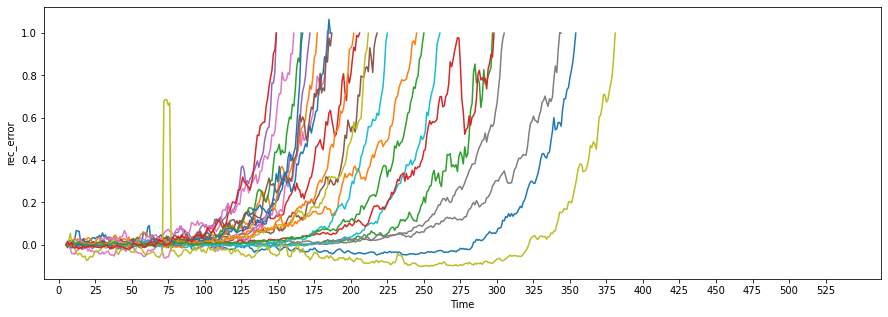

In [45]:
plot = pl.Plots(tr_df)
plot.timeplot_column('rec_error')

In [83]:
# 1. Get Normal Operating Data
X = tr_df.df[[tr_df.id_col] + tr_df.data_cols].copy()
XX = np.array(tr_df.df[tr_df.data_cols]).copy()
for i, d in X.groupby(tr_df.id_col):
    q25 = int(d.shape[0] * normal_operation) + 1
    X = X.drop(range(d.index[0] + q25, d.index[-1] + 1))
X = X.drop(columns = tr_df.id_col)
X = np.asarray(X, dtype=float)

In [ ]:
# 2. Train Autoencoder (here vanilla autoencoder)
ae = vae_class.Autoencoder(input_dim = input_dim)
ae.compile(optimizer = 'Adam', loss = 'MSE')
ae.fit(X, X, epochs = 20)

In [ ]:
# 3. Calculate Reconstruction Error
prediction = ae.predict(XX)
reconstruction_error = tf.metrics.mean_squared_error(XX, prediction)
tr_df.df['rec_error'] = reconstruction_error
tr_df.label_cols.append('rec_error')
plots.timeplot_column('rec_error')

In [ ]:
# 3. Calculate Fault Steps (here highest acceleration)
scale, fault_times, fault_indeces = preproc.highest_acceleration(tr_df, 'rec_error', p = 0.1, q = normal_operation)

Vizualize Fault Steps

In [9]:
def visualize_fault_step(rul_df, col, asset, faultsteps, q = normal_operation) -> None:
    data = rul_df.df.loc[rul_df.df[rul_df.id_col] == asset]
    max_time = data[rul_df.time_col].max()
    timestep_normal = int(max_time * normal_operation) + 1
    plt.figure(figsize=(15,5))
    plt.plot(rul_df.time_col, col, data = data)
    plt.axvline(x = faultsteps[asset-1], color = 'red')
    plt.axvline(x = timestep_normal, color = 'green')
    plt.xlim(-10, max_time + 20)
    plt.xticks(np.arange(0, max_time, 25))
    plt.ylabel(col)
    plt.xlabel('Time')
    plt.show()

In [210]:
scale_optimized, fault_times, fault_indeces = preproc.acceleration_threshold(tr_df, 'rec_error', p = 0.08 , s = 2.0, q = normal_operation)

Asset 1


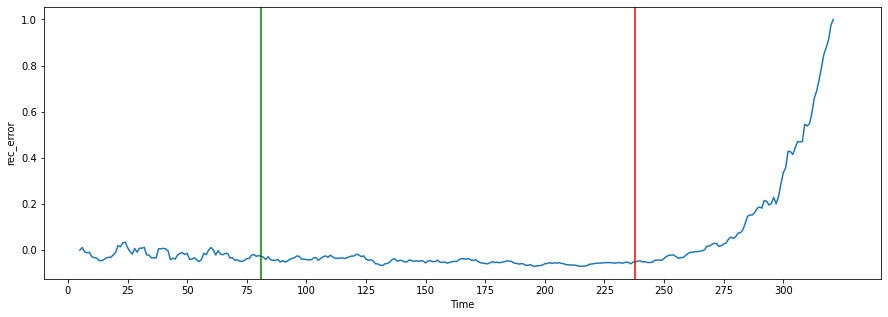

Asset 2


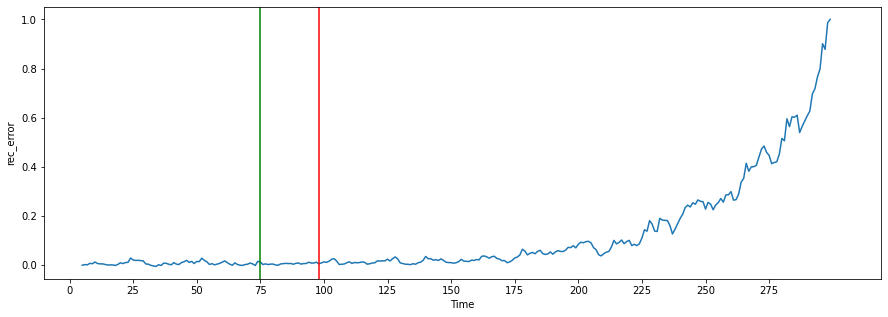

Asset 3


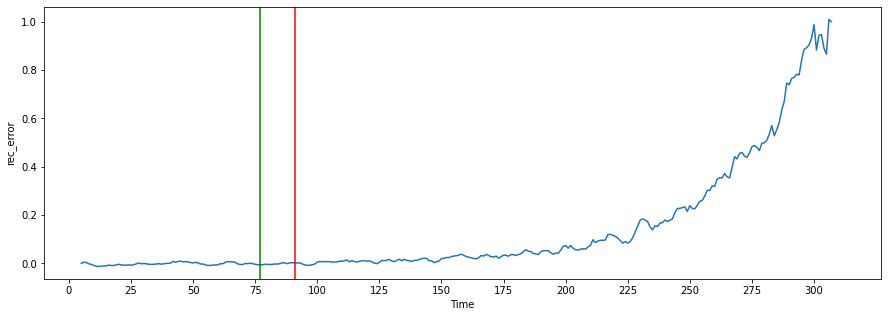

Asset 4


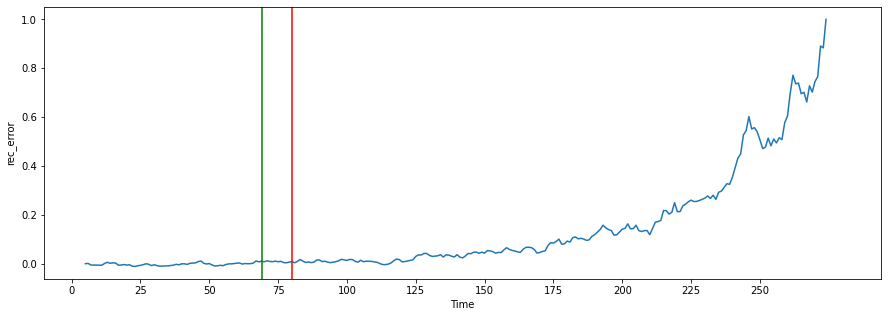

Asset 5


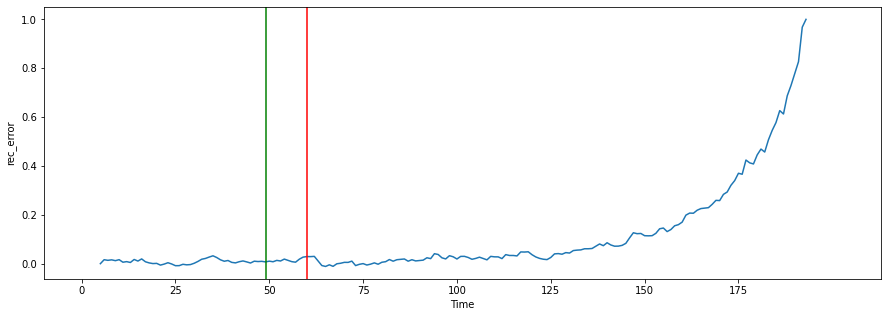

Asset 6


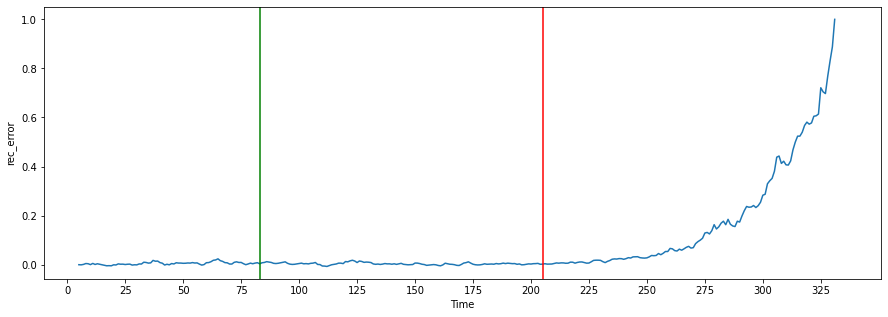

Asset 7


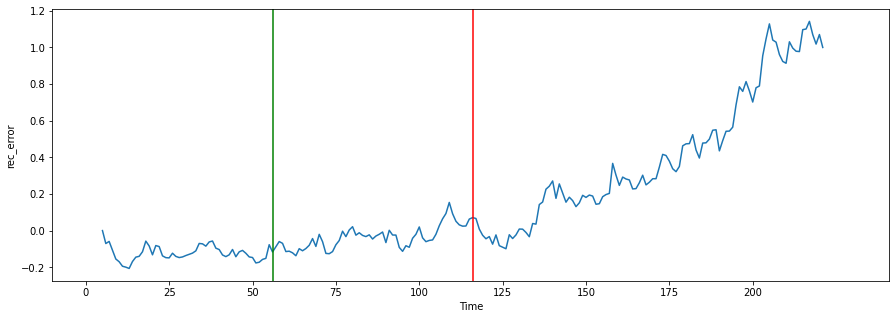

Asset 8


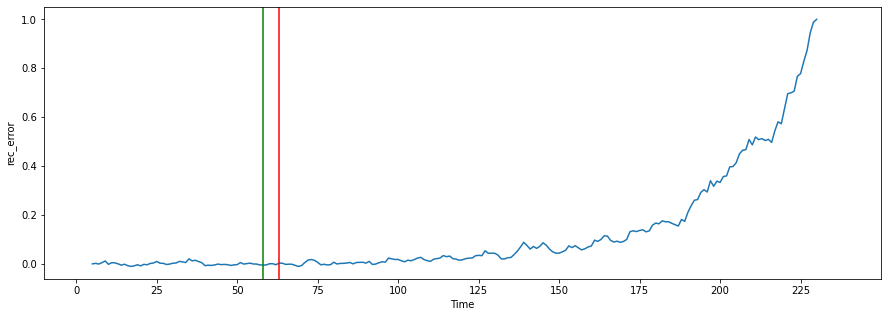

Asset 9


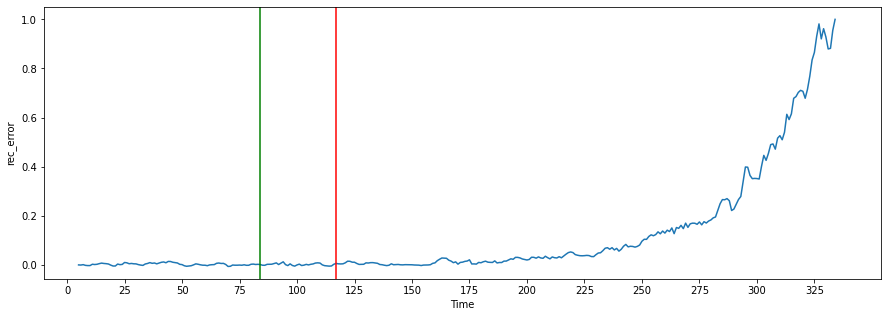

Asset 10


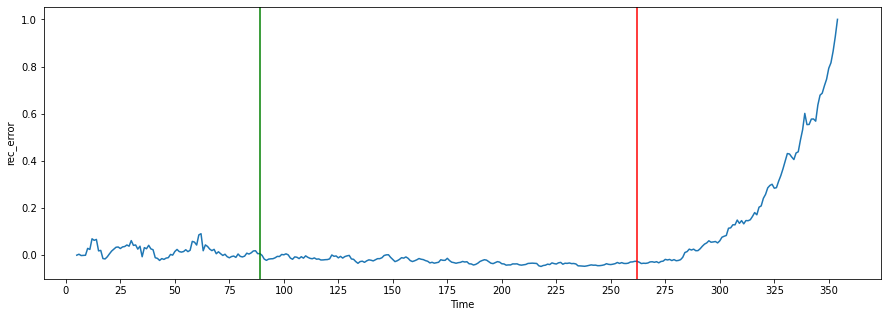

Asset 11


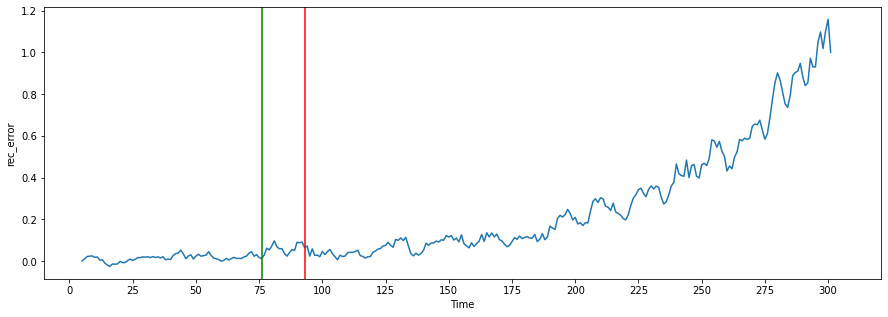

Asset 12


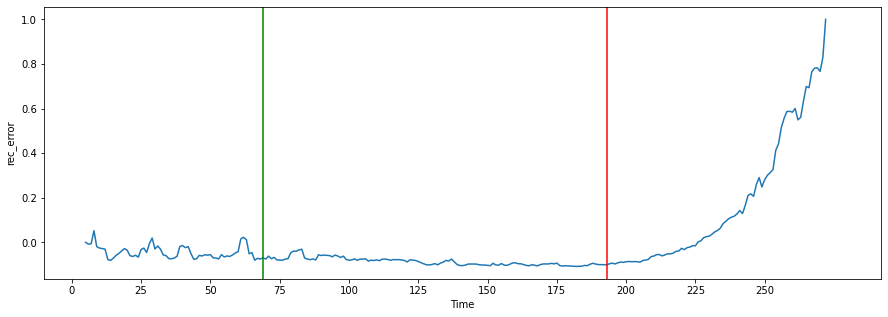

Asset 13


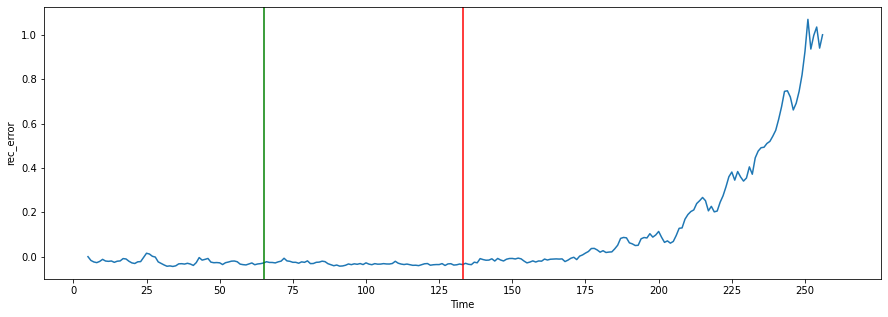

Asset 14


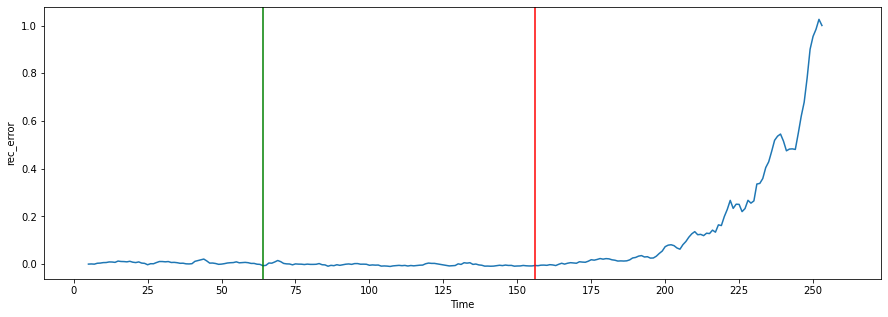

Asset 15


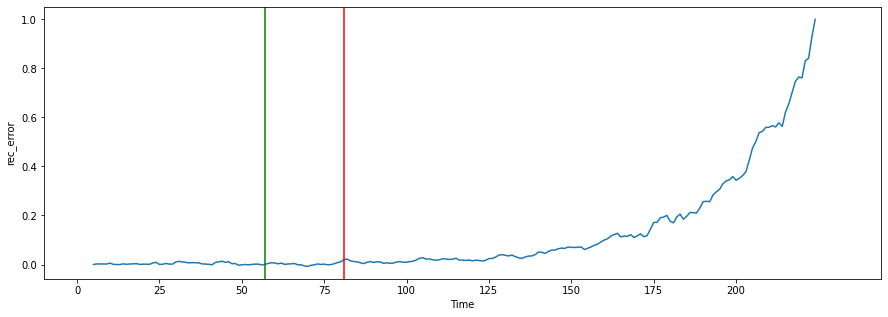

Asset 16


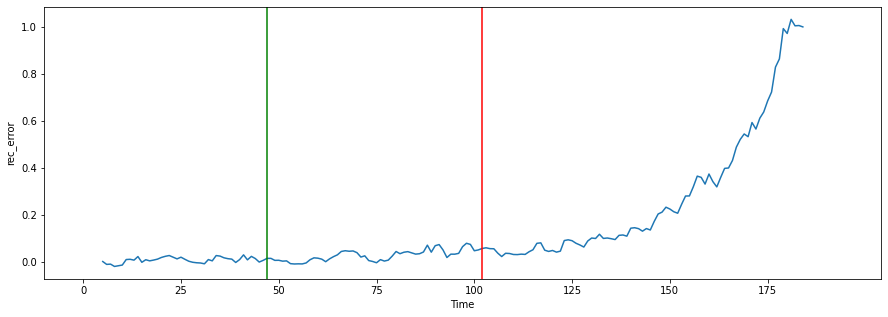

Asset 17


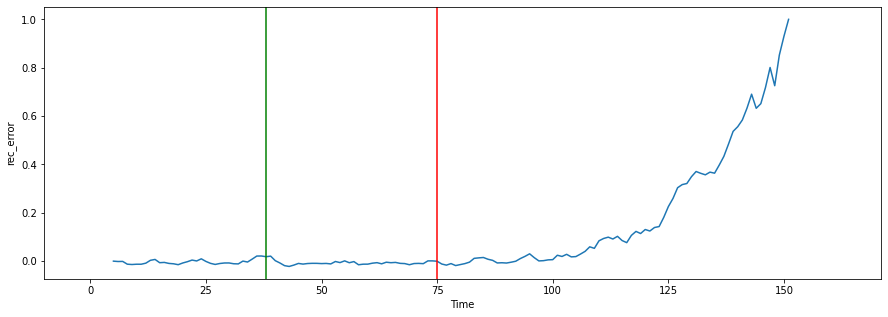

Asset 18


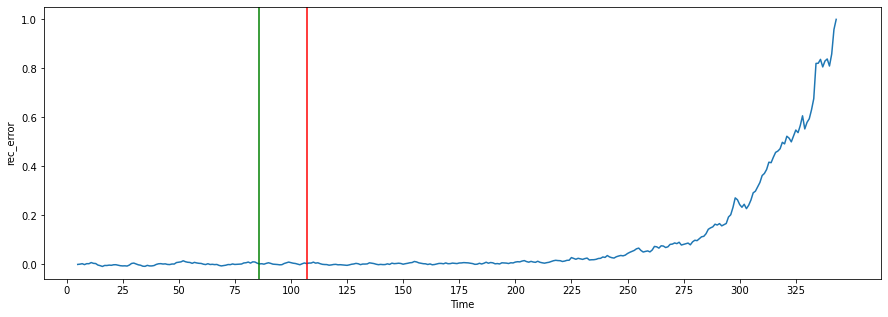

Asset 19


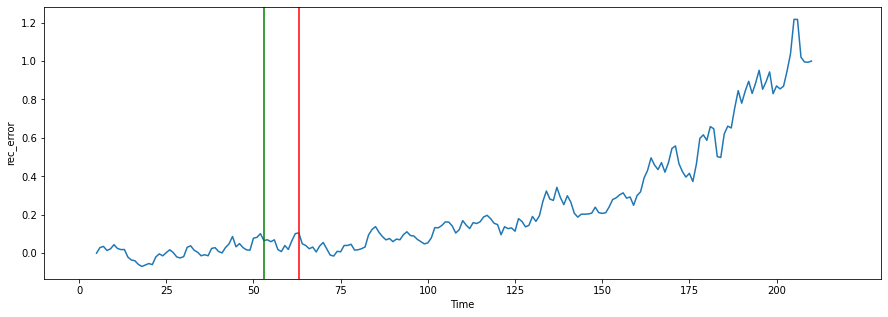

Asset 20


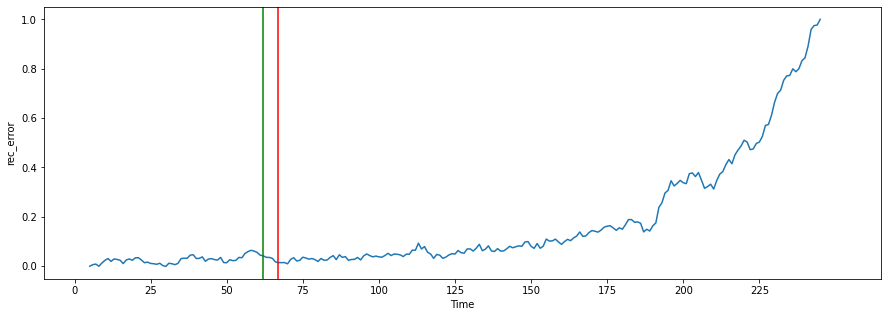

Asset 21


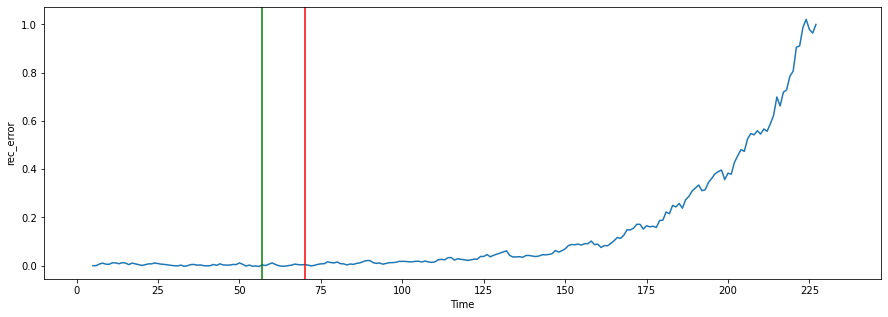

Asset 22


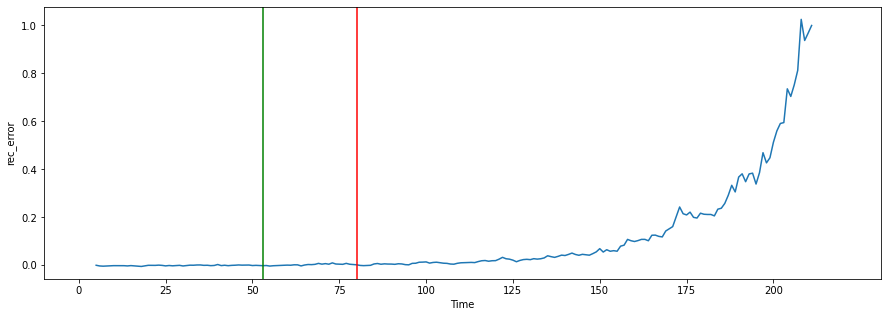

Asset 23


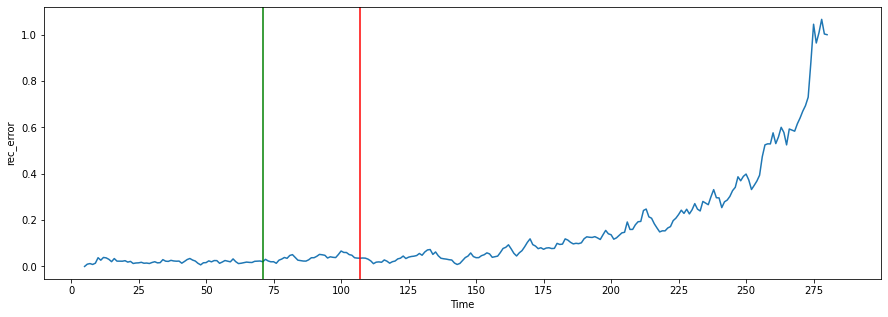

Asset 24


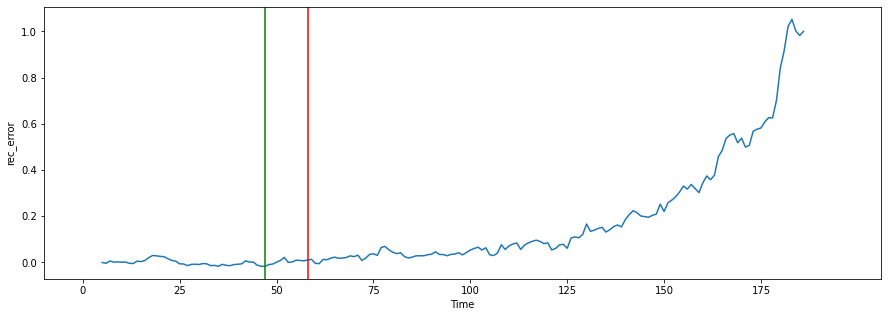

Asset 25


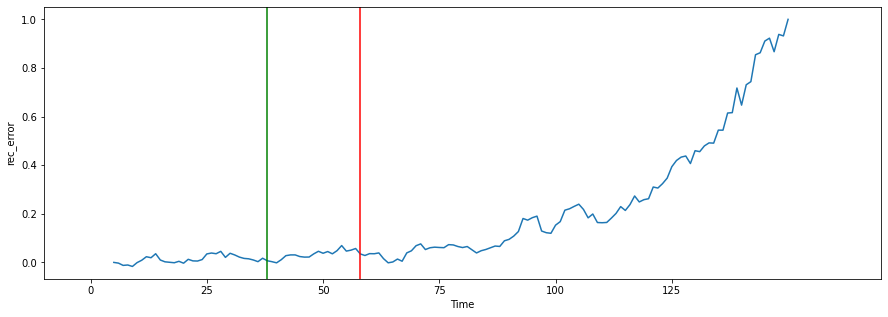

Asset 26


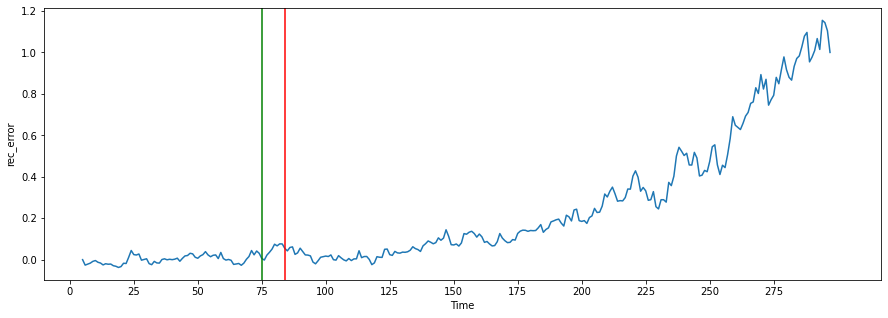

Asset 27


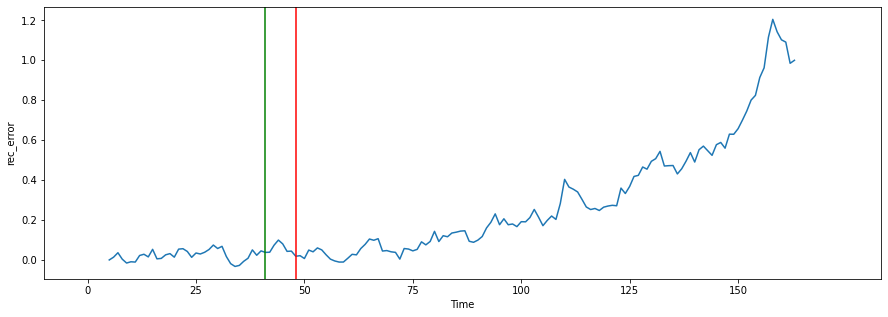

Asset 28


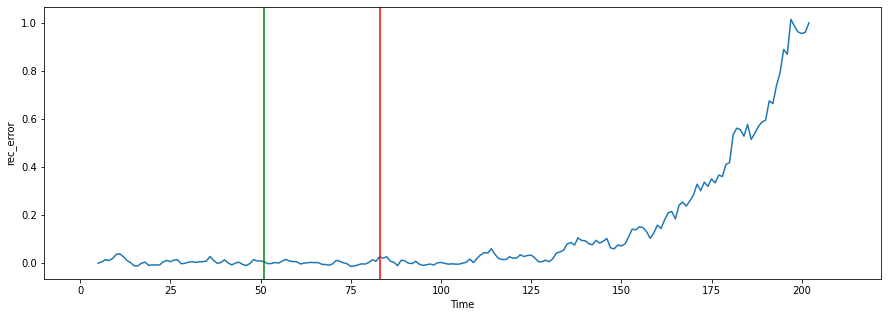

Asset 29


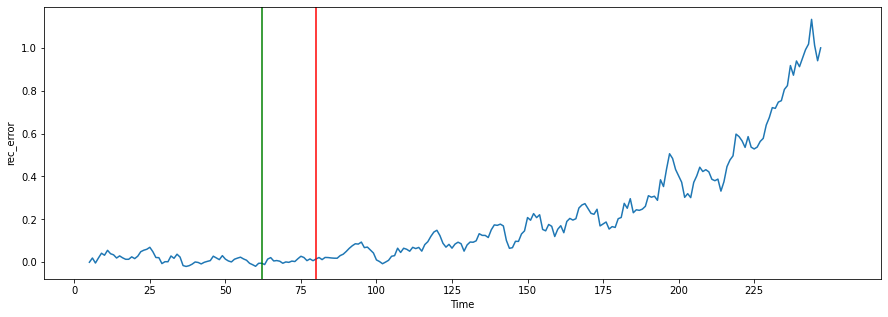

Asset 30


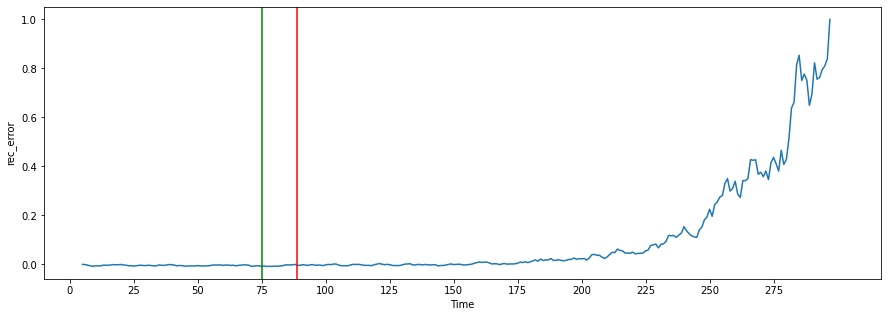

Asset 31


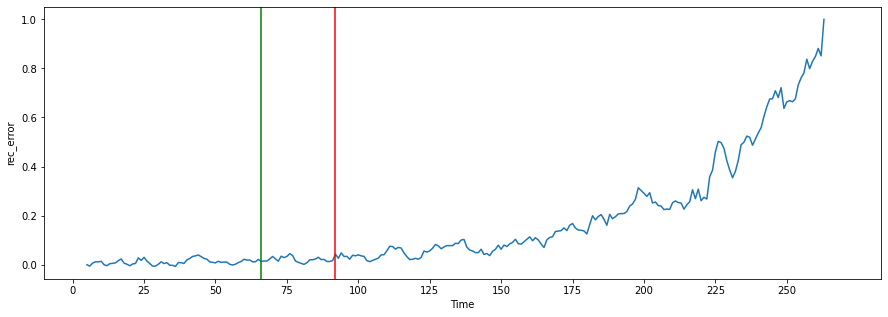

Asset 32


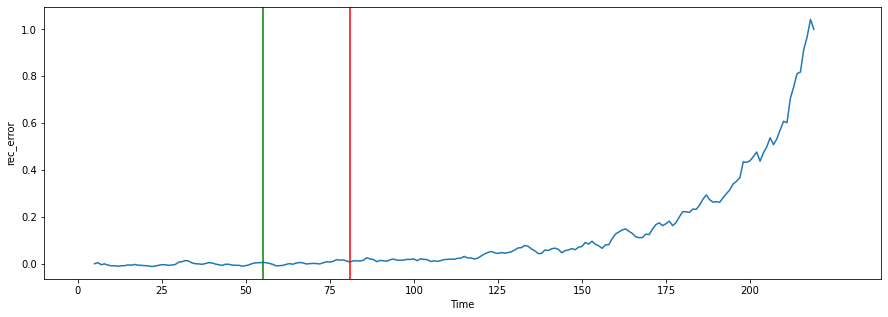

Asset 33


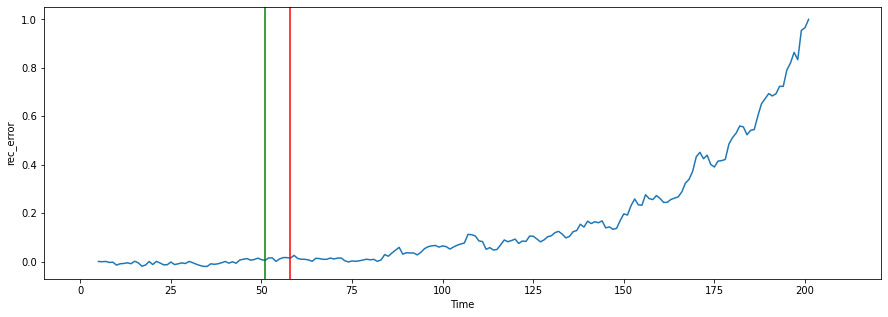

Asset 34


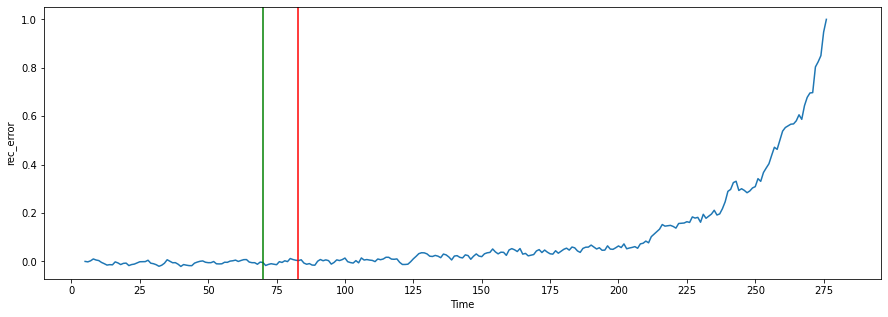

Asset 35


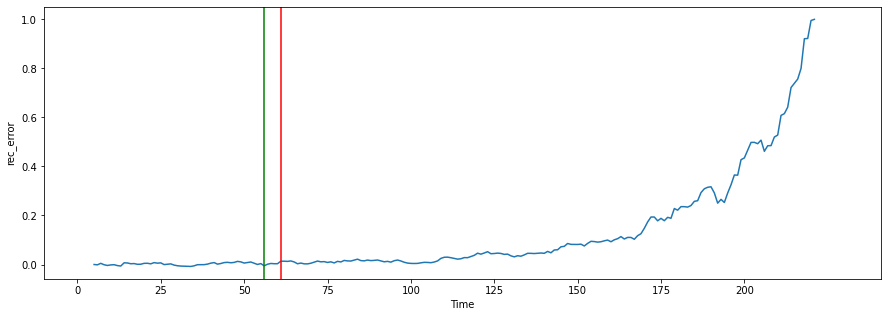

Asset 36


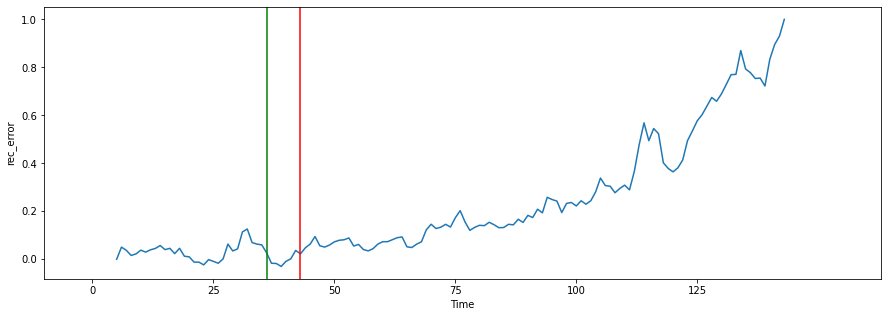

Asset 37


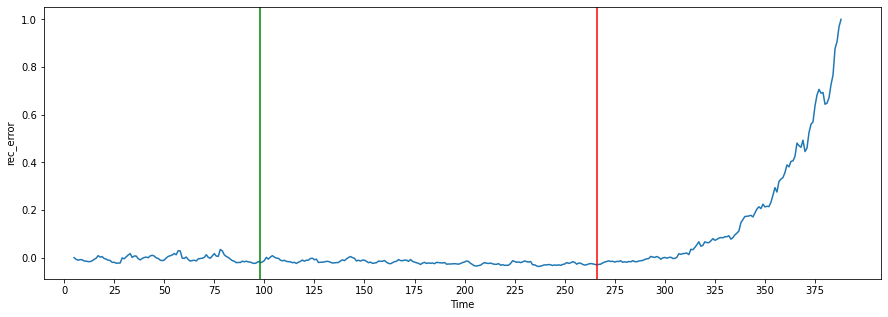

Asset 38


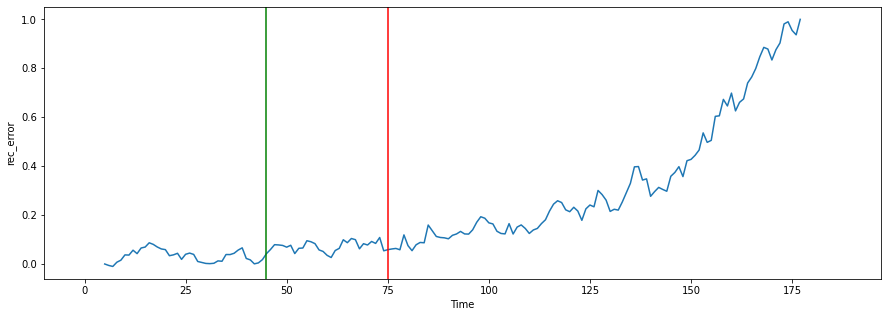

Asset 39


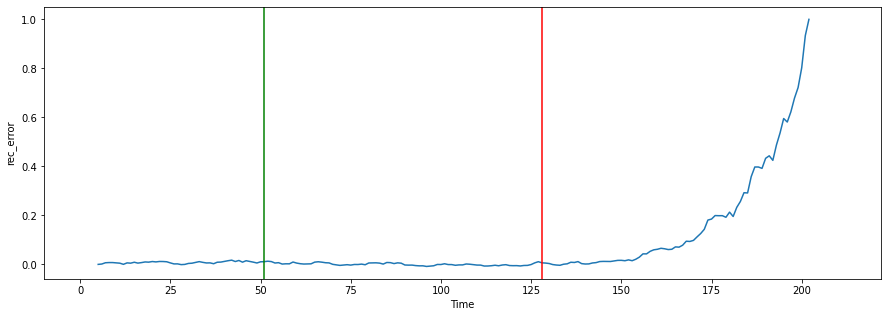

Asset 40


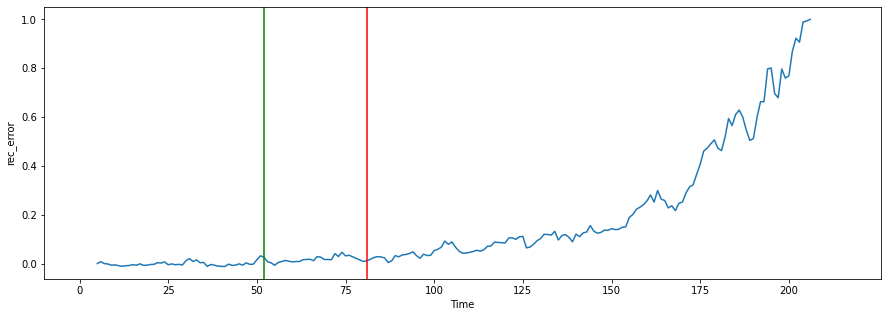

Asset 41


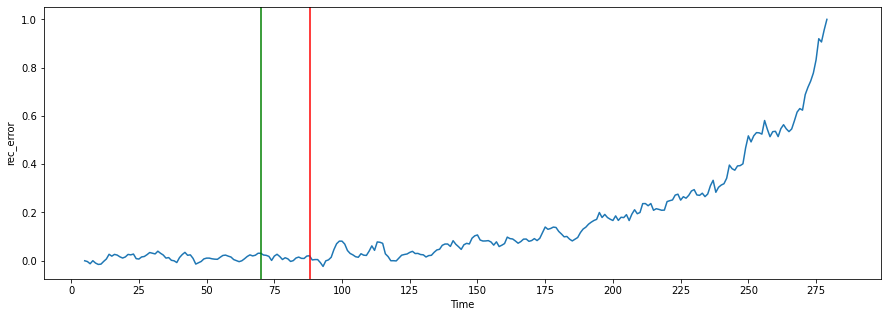

Asset 42


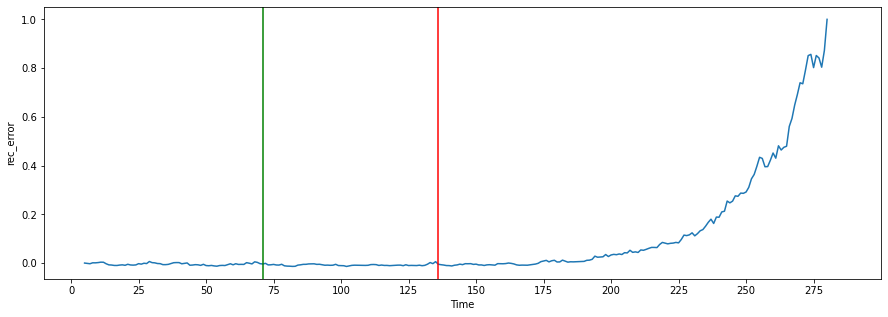

Asset 43


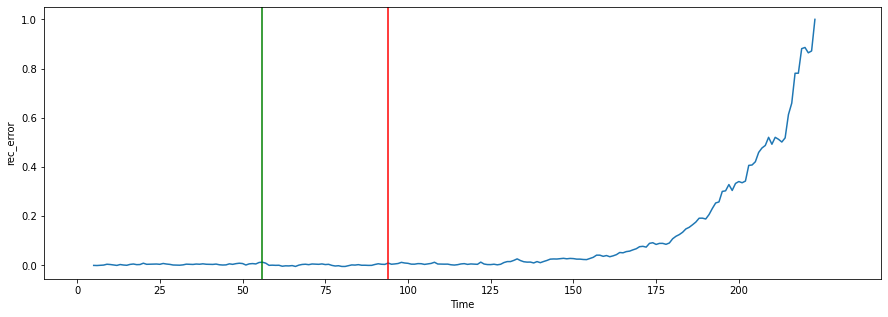

Asset 44


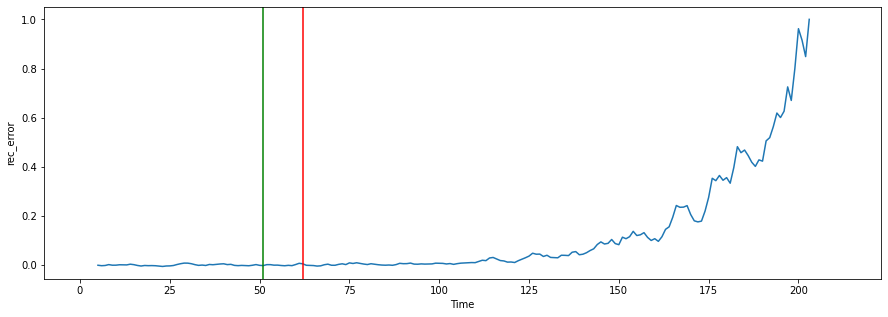

Asset 45


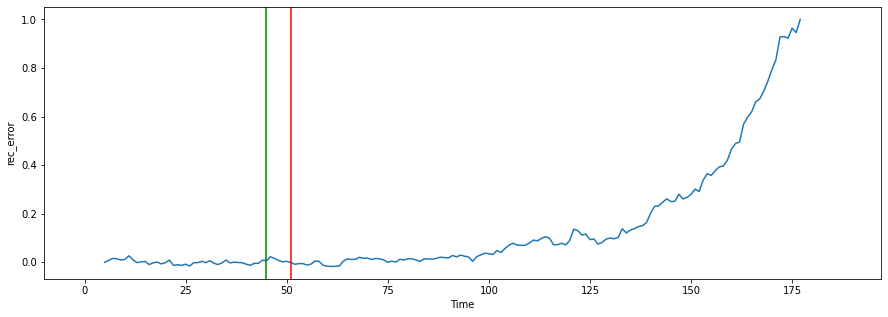

Asset 46


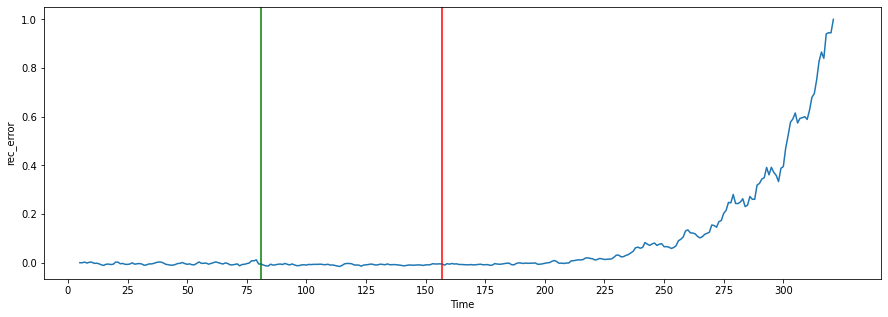

Asset 47


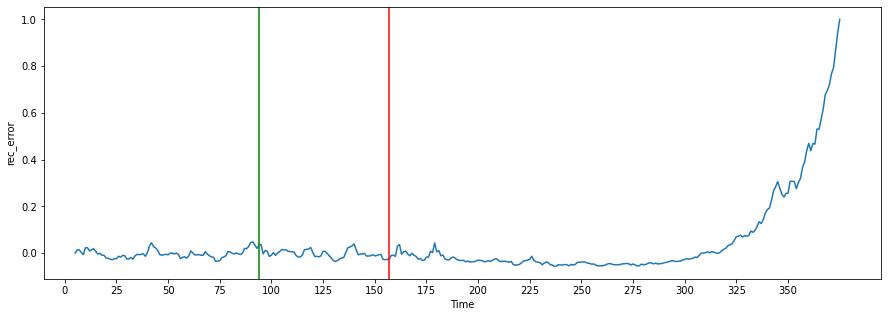

Asset 48


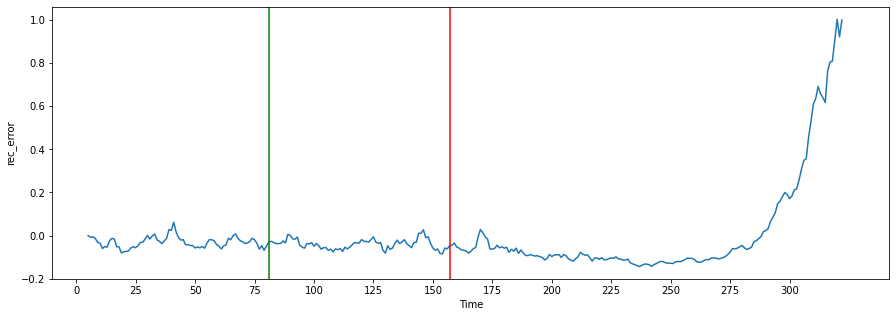

Asset 49


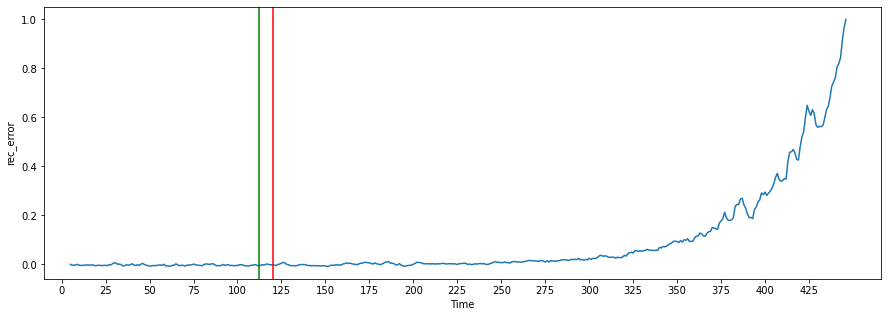

In [216]:
from random import randint
for i in range(1, 50):
    print(f'Asset {i}')
    visualize_fault_step(tr_df, 'rec_error', i, fault_times)

In [15]:
fault_times[92]

97

In [111]:
tr_df.df.loc[tr_df.df[tr_df.id_col] == 93]

,id,dt,set1,set2,set3,s2,s3,s4,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,linear,rec_error
18856,93,1,-0.0032,-0.0001,100.0,-0.341839,-1.765310,-0.664836,1.324514,-0.375461,...,-1.539489,1.364721,-0.919841,-0.246005,-0.129201,-1.427402,1.182510,0.557927,154,0.000000
18857,93,2,-0.0029,0.0001,100.0,-1.241765,-1.142247,-1.608129,0.657901,-1.079848,...,-1.876466,0.334262,-0.919841,-0.122812,-0.171863,-0.781710,0.961200,1.017057,153,0.000540
18858,93,3,-0.0035,-0.0004,100.0,-1.601735,-1.094947,-2.235880,0.827379,-0.516338,...,-0.453676,1.066430,-1.476037,-0.155314,-0.785129,-0.136018,0.684563,0.843382,152,0.005208
18859,93,4,0.0013,0.0004,100.0,-2.081696,-0.970986,-1.485912,0.714393,-0.657216,...,-1.614373,1.256251,-1.336988,0.050707,-1.683697,-2.073094,1.182510,1.475263,151,0.048476
18860,93,5,0.0023,0.0004,100.0,-0.041864,-1.220538,-1.573686,1.629574,-0.234584,...,-1.314838,1.174899,-1.754134,0.025020,-1.203750,-0.781710,0.684563,0.187482,150,0.010432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19006,93,151,0.0034,-0.0002,100.0,1.498010,1.330432,3.093891,-2.550882,2.301208,...,1.717951,-1.957153,2.278282,-0.274838,1.798586,2.446751,-2.303120,-2.545125,4,0.989784
19007,93,152,0.0014,0.0001,100.0,1.817983,1.214627,1.951718,-2.065045,1.315066,...,2.167253,-3.001171,1.722087,-0.528563,2.070557,1.155367,-1.971155,-1.567742,3,0.759145
19008,93,153,0.0024,0.0000,100.0,2.177954,1.475596,2.210596,-1.545313,3.005594,...,2.167253,-2.553735,1.722087,-0.015870,1.795920,2.446751,-1.362553,-1.394067,2,0.921329
19009,93,154,-0.0003,-0.0001,100.0,2.117959,2.330269,3.274995,-2.901136,1.737698,...,2.242136,-2.146975,2.417331,-0.066195,2.377189,1.801059,-2.856395,-2.091538,1,1.142772


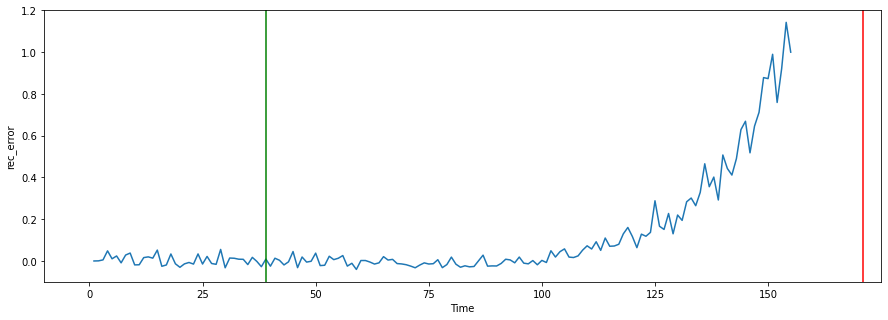

In [110]:
visualize_fault_step(tr_df, 'rec_error', 93, fault_times)

Also tried using Kmeans but results were worse.

In [37]:
# Not accurate, choose acceleration_theshold!
classy.fit_kmeans(tr_df, cols = ['vae_rec_error'], n = 2, colname = 'kmeans_normal_faulty')
scale_k, fault_times_k, fault_indeces_k = preproc.get_classy_change_step(tr_df, col = 'kmeans_normal_faulty')

In [38]:
def visualize_kmeans_step(rul_df, col, colkmeans, asset, faultsteps, mod = 10) -> None:
    assets = rul_df.df[rul_df.id_col].unique()
    max_time = rul_df.df[rul_df.time_col].max()
    kmeans_mask_0 = rul_df.df.loc[rul_df.df[colkmeans] == 0]
    kmeans_mask_1 = rul_df.df.loc[rul_df.df[colkmeans] == 1]
    plt.figure(figsize=(15,5))
    plt.plot(rul_df.time_col, col, data = kmeans_mask_0.loc[kmeans_mask_0[rul_df.id_col] == asset])
    plt.plot(rul_df.time_col, col, data = kmeans_mask_1.loc[kmeans_mask_1[rul_df.id_col] == asset])
    plt.axvline(x = faultsteps[asset-1])
    plt.xlim(-10, max_time + 20)
    plt.xticks(np.arange(0, max_time, 25))
    plt.ylabel(col)
    plt.xlabel('Time')
    plt.show()

Asset 97


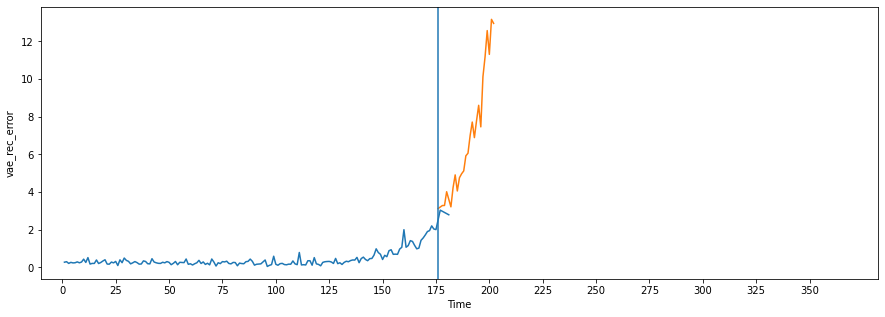

Asset 89


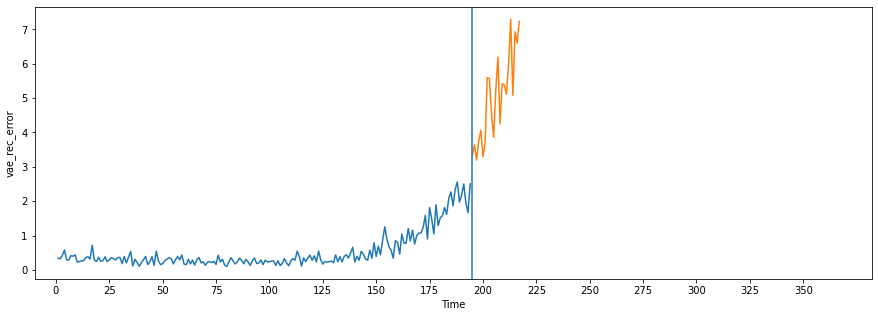

Asset 30


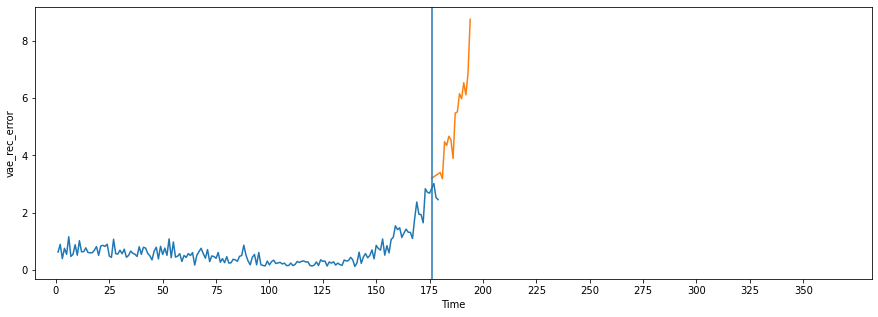

Asset 88


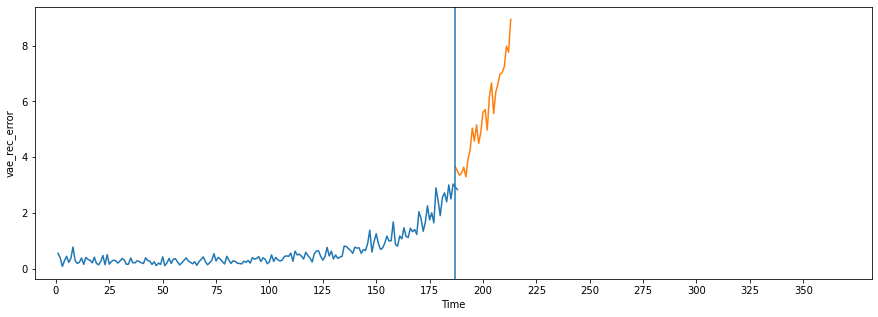

Asset 83


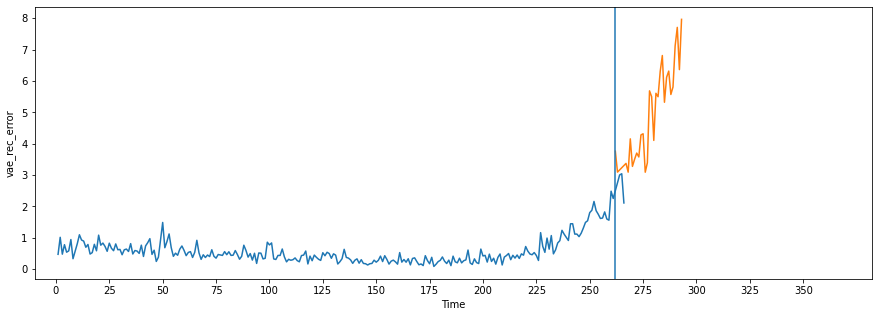

Asset 99


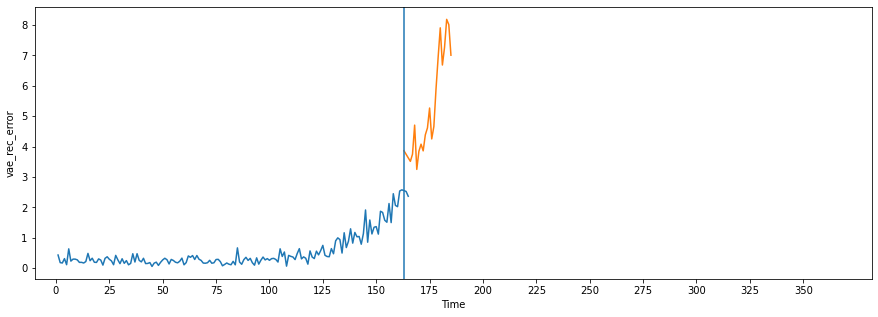

Asset 57


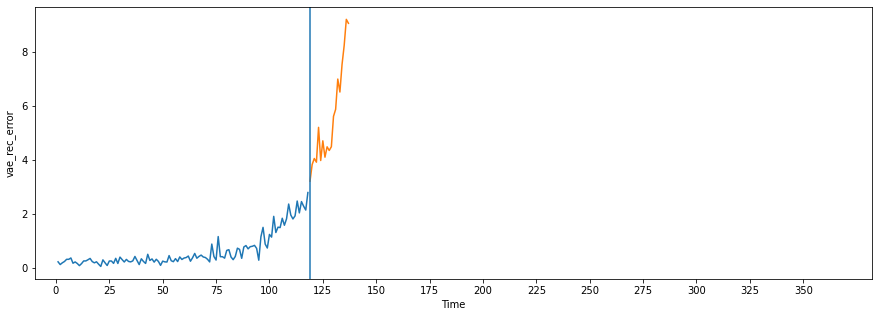

Asset 44


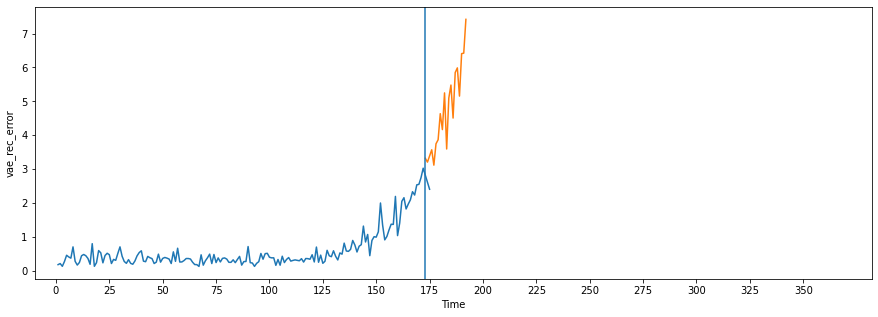

Asset 87


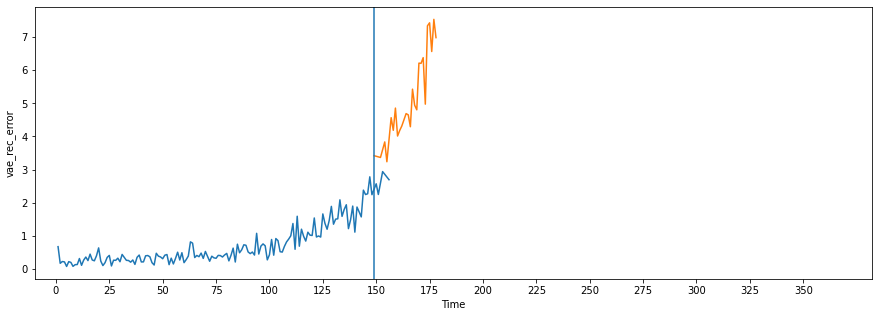

Asset 63


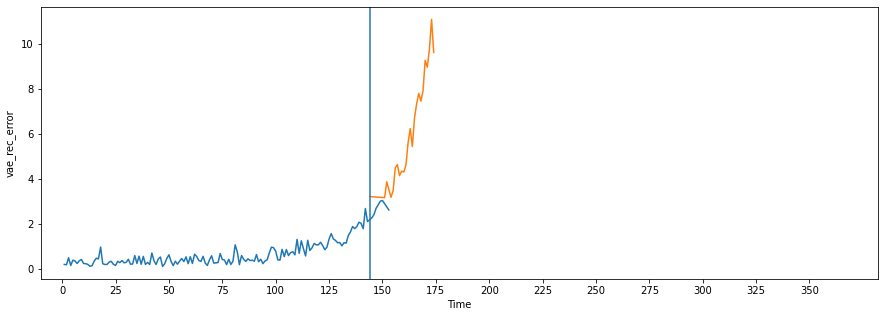

In [39]:
for i in range(10):
    j = randint(0, len(tr_df.df[tr_df.id_col].unique()))
    print(f'Asset {j}')
    visualize_kmeans_step(tr_df, col = 'vae_rec_error', colkmeans = 'kmeans_normal_faulty', asset = j, faultsteps = fault_times_k)